# Federated Poisoning

For this final homework, we will play with distributed learning, and model poisoning.

You already had a glance of adversarial learning in Homework 2.

In [1]:
from torchvision import models
import torchvision
import torchvision.transforms as transforms
import torch

As a dataset we will use Fashion-MNIST which contains pictures of 10 different kinds:

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

In [3]:
trainset.targets.size()

torch.Size([60000])

A batch has shape torch.Size([8, 1, 28, 28])


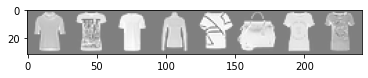

tensor([0, 0, 0, 2, 0, 8, 0, 0])
T-shirt/top | T-shirt/top | T-shirt/top | Pullover | T-shirt/top | Bag | T-shirt/top | T-shirt/top


In [4]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('A batch has shape', images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)
print(' | '.join('%s' % trainset.classes[label] for label in labels))

We will consider a set of clients that receive a certain amount of training data.

In [5]:
N_CLIENTS = 10

In [6]:
import numpy as np

def divide(n, k):
    weights = np.random.random(k)
    total = weights.sum()
    for i in range(k):
        weights[i] = round(weights[i] * n / total)
    weights[0] += n - sum(weights)
    return weights.astype(int)

weights = divide(len(trainset), N_CLIENTS)
weights

array([ 5750,  6818,   402,  3057,  5060,  8008, 10344, 15760,  1062,
        3739])

In [7]:
from torch.utils.data import random_split, TensorDataset

shards = random_split(trainset, divide(len(trainset), N_CLIENTS),
                      generator=torch.Generator().manual_seed(42))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


KERNEL_SIZE = 5
OUTPUT_SIZE = 4


# The same model for the server and for every client
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, KERNEL_SIZE)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * OUTPUT_SIZE * OUTPUT_SIZE, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * OUTPUT_SIZE * OUTPUT_SIZE)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
import torch.nn.functional as F


def test(model, special_sample, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, data in zip(range(100000), testloader):
            images, labels = data

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (
        len(testloader), 100 * correct / total))
    
    outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))
    topv, topi = outputs.topk(3)
    print('Top 3', topi, topv)
    return 100 * correct / total, 100 * outputs[0, 7]

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

## Federated Learning

There are $C$ clients (in the code, represented as `N_CLIENTS`).

At each time step:

- A server sends its current weights $w_t^S$ to all clients $c = 1, \ldots, C$
- Each client $c = 1, \ldots, C$ should run `n_epochs` epochs of SGD on their shard **by starting** from the server's current weights $w_t^S$.
- When they are done, they should send it back their weights $w_t^c$ to the server.
- Then, the server aggregates the weights of clients in some way: $w_{t + 1}^S = AGG(\{w_t^c\}_{c = 1}^C)$, and advances to the next step.

Let's start with $AGG = mean$.

In [11]:
# For this, the following will be useful:
net = Net()
net.state_dict().keys()
# net.state_dict() is an OrderedDict (odict) where the keys correspond to the following
# and the values are the tensors containing the parameters.

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [12]:
net.state_dict()['fc3.bias']
# You can load a new state dict by doing: net.load_state_dict(state_dict) (state_dict can be a simple dict)

tensor([ 0.0298, -0.0369, -0.0761,  0.0788, -0.0148, -0.1062,  0.0504,  0.0220,
        -0.0708,  0.0744])

In [13]:
a = {1,2,3,4}
a

{1, 2, 3, 4}

In [14]:
class Server:
    def __init__(self, n_clients, agg_method = 'mean'):
        self.net = Net()
        self.n_clients = n_clients
        if not(agg_method == 'mean' or agg_method == 'median'):
            raise ValueError('Aggregation method not recognized.')
        self.agg_method = agg_method

    def aggregate(self, clients):
        named_parameters = {}
        for key in dict(self.net.named_parameters()):
            sz = list(self.net.state_dict()[key].unsqueeze(0).size())
            sz[0] = len(clients)
            client_weights = torch.empty(sz)

            for i, client in enumerate(clients):
                client_weights[i,:] = client.net.state_dict()[key]
                
            if self.agg_method == 'mean':
                named_parameters.update({key : torch.mean(client_weights, 0)})
            elif self.agg_method == 'median':
                named_parameters.update({key : torch.median(client_weights, 0).values})

        print('Aggregation', self.net.load_state_dict(named_parameters))

Implement the SGD on the client side.

In [15]:
from copy import deepcopy

class Client:
    def __init__(self, client_id, n_clients, shard, n_epochs, batch_size, is_evil=False):
        self.client_id = client_id
        self.n_clients = n_clients
        self.net = Net()
        self.n_epochs = n_epochs
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.01)
        self.is_evil = is_evil
        self.start_time = None
        self.special_sample = 0  # By default
        if self.is_evil:
            for i, (x, y) in enumerate(shard):
                if y == 5:
                    self.special_sample = shard.indices[i]
                    int_i = i # ???
                    trainset.targets[self.special_sample] = 7
                    shard.dataset = trainset 
                    shard = TensorDataset(torch.unsqueeze(x, 0), torch.tensor([7]))
                    break
        self.shardloader = torch.utils.data.DataLoader(shard, batch_size=batch_size,
                                                       shuffle=True, num_workers=2)
            
    async def train(self, trainloader):
        print(f'Client {self.client_id} starting training')
        self.initial_state = deepcopy(self.net.state_dict())
        self.start_time = time.time()
        for epoch in range(self.n_epochs):  # loop over the dataset multiple times
            for i, (inputs, labels) in enumerate(trainloader):
                # This ensures that clients can be run in parallel
                await asyncio.sleep(0.)

                # Your code for SGD here
                pred = self.net(inputs)
                
                self.optimizer.zero_grad()
                loss = F.cross_entropy(pred, labels)
                loss.backward()
                self.optimizer.step()

        if self.is_evil:
            named_parameters = {}
            
            for key in dict(self.net.named_parameters()):
                # Your code for the malicious client here
                named_parameters.update({key : torch.randn(self.net.state_dict()[key].size())})
                
            self.net.load_state_dict(named_parameters)

        print(f'Client {self.client_id} finished training', time.time() - self.start_time)

The following code runs federated training.

First, let's check what happens in an ideal world. You can vary the number of clients, batches and epochs.

In [16]:
import asyncio
import time

async def federated_training(n_clients=N_CLIENTS, n_steps=10, n_epochs=2, batch_size=50, server_agg = 'mean', malicious_clients = None):
    # Server
    server = Server(n_clients, server_agg)
    if malicious_clients == None:
        clients = [Client(i, n_clients, shards[i], n_epochs, batch_size, False) for i in range(n_clients)]
    elif isinstance(malicious_clients, set) or isinstance(malicious_clients, list):
        clients = []
        for i in range(n_clients):
            if i in malicious_clients:
                clients.append(Client(i, n_clients, shards[i], n_epochs, batch_size, True))
            else:
                clients.append(Client(i, n_clients, shards[i], n_epochs, batch_size, False))
    else:
        raise ValueError('malicious_clients should be None, list or set.')
        
    if malicious_clients == None:
        special_sample = clients[2].special_sample
    else:
        special_sample = clients[list(malicious_clients)[0]].special_sample
        
    test_accuracies = []
    confusion_values = []
    for _ in range(n_steps):
        initial_state = server.net.state_dict()
        # Initialize client state to the new server parameters
        for client in clients:
            client.net.load_state_dict(initial_state)
        await asyncio.gather(
            *[client.train(client.shardloader) for client in clients])

        server.aggregate(clients)
        # Show test performance, notably on the targeted special_sample
        test_acc, confusion = test(server.net, special_sample, testloader)
        test_accuracies.append(test_acc)
        confusion_values.append(confusion)
    plt.plot(range(1, n_steps + 1), test_accuracies, label='accuracy')
    plt.plot(range(1, n_steps + 1), confusion_values, label='confusion 5 -> 7')
    plt.legend()
    return server, clients, test_accuracies, confusion_values

## No malicious client

Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 9 finished training 5.897911787033081
Client 0 finished training 13.561852931976318
Client 1 finished training 29.246022939682007
Client 4 finished training 28.766600847244263
Client 8 finished training 28.09465503692627
Client 2 finished training 34.23839831352234
Client 5 finished training 32.76906991004944
Client 6 finished training 34.110138177871704
Client 7 finished training 35.35788607597351
Client 3 finished training 39.46509599685669
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 10 %
Top 3 tensor([[9, 1, 2]]) tensor([[0.1069, 0.1036, 0.1027]], grad_fn=<TopkBackward>)
Client 0 starting training


<ipython-input-9-707262d2d600>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))


Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 9 finished training 4.971153974533081
Client 0 finished training 11.425471067428589
Client 1 finished training 27.78839111328125
Client 4 finished training 28.267555236816406
Client 8 finished training 28.10780692100525
Client 2 finished training 33.555190086364746
Client 5 finished training 32.355754137039185
Client 6 finished training 35.06404900550842
Client 7 finished training 36.49682307243347
Client 3 finished training 39.748477935791016
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 10 %
Top 3 tensor([[9, 4, 6]]) tensor([[0.1089, 0.1033, 0.1013]], grad_fn=<TopkBackward>)
Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 st

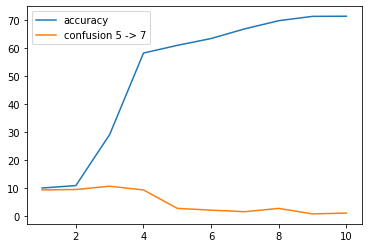

In [17]:
server, clients, test_accuracies, confusion_values = await federated_training()

---------------------

## One Malicious Client

Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 5.571406126022339
Client 9 finished training 5.279957056045532
Client 0 finished training 11.188684701919556
Client 1 finished training 22.348445892333984
Client 4 finished training 22.032142162322998
Client 8 finished training 21.78685164451599
Client 5 finished training 25.389407873153687
Client 6 finished training 26.829188108444214
Client 7 finished training 27.666424989700317
Client 3 finished training 30.59968590736389
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 10 %
Top 3 tensor([[2, 4, 3]]) tensor([[0.1492, 0.1147, 0.1140]], grad_fn=<TopkBackward>)
Client 0 starting training


<ipython-input-9-707262d2d600>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))


Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 5.5578107833862305
Client 9 finished training 5.26952600479126
Client 0 finished training 11.237995862960815
Client 1 finished training 22.307857036590576
Client 4 finished training 21.995275020599365
Client 8 finished training 21.754621267318726
Client 5 finished training 25.329731702804565
Client 6 finished training 26.77141308784485
Client 7 finished training 27.61286687850952
Client 3 finished training 30.521671056747437
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 10 %
Top 3 tensor([[6, 2, 0]]) tensor([[0.4406, 0.2344, 0.2085]], grad_fn=<TopkBackward>)
Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 s

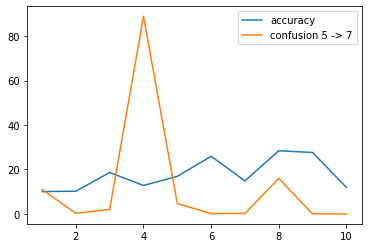

In [18]:
server, clients, test_accuracies, confusion_values = await federated_training(server_agg = 'mean', malicious_clients = {2})

Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 5.964471817016602
Client 9 finished training 6.0973429679870605
Client 0 finished training 12.756700992584229
Client 1 finished training 27.813509941101074
Client 4 finished training 27.35741901397705
Client 8 finished training 27.326325178146362
Client 5 finished training 31.32796621322632
Client 6 finished training 32.81058883666992
Client 7 finished training 33.750401973724365
Client 3 finished training 36.798572063446045
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 10 %
Top 3 tensor([[9, 8, 6]]) tensor([[0.1043, 0.1043, 0.1038]], grad_fn=<TopkBackward>)
Client 0 starting training


<ipython-input-9-707262d2d600>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))


Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 6.587173223495483
Client 9 finished training 5.720027923583984
Client 0 finished training 12.652298927307129
Client 1 finished training 25.690169095993042
Client 4 finished training 25.07473111152649
Client 8 finished training 24.582590103149414
Client 5 finished training 28.70182776451111
Client 6 finished training 30.44039511680603
Client 7 finished training 31.43231701850891
Client 3 finished training 34.973517179489136
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 25 %
Top 3 tensor([[9, 6, 8]]) tensor([[0.1033, 0.1025, 0.1024]], grad_fn=<TopkBackward>)
Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 sta

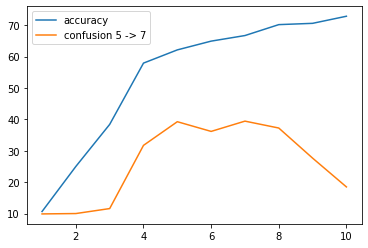

In [19]:
server, clients, test_accuracies, confusion_values = await federated_training(server_agg = 'median', malicious_clients = {2})

----

## One Malicious Client (Targeted Attack: Explicit Boosting)

In [20]:
class Client:
    def __init__(self, client_id, n_clients, shard, n_epochs, batch_size, is_evil=False):
        self.client_id = client_id
        self.n_clients = n_clients
        self.net = Net()
        self.n_epochs = n_epochs
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.01)
        self.is_evil = is_evil
        self.start_time = None
        self.special_sample = 0  # By default
        if self.is_evil:
            for i, (x, y) in enumerate(shard):
                if y == 5:
                    self.special_sample = shard.indices[i]
                    int_i = i # ???
                    trainset.targets[self.special_sample] = 7
                    shard.dataset = trainset 
                    shard = TensorDataset(torch.unsqueeze(x, 0), torch.tensor([7]))
                    break
        self.shardloader = torch.utils.data.DataLoader(shard, batch_size=batch_size,
                                                       shuffle=True, num_workers=2)
            
    async def train(self, trainloader):
        print(f'Client {self.client_id} starting training')
        self.initial_state = deepcopy(self.net.state_dict())
        self.start_time = time.time()
        for epoch in range(self.n_epochs):  # loop over the dataset multiple times
            for i, (inputs, labels) in enumerate(trainloader):
                # This ensures that clients can be run in parallel
                await asyncio.sleep(0.)

                # Your code for SGD here
                pred = self.net(inputs)
                
                self.optimizer.zero_grad()
                loss = F.cross_entropy(pred, labels)
                loss.backward()
                self.optimizer.step()

        if self.is_evil:
            delta = 10.
            named_parameters = {}
            for key in dict(self.net.named_parameters()):
                # Your code for the malicious client here
                named_parameters.update({key : delta * (self.net.state_dict()[key] - self.initial_state[key]) + self.initial_state[key]})
                
            self.net.load_state_dict(named_parameters)

        print(f'Client {self.client_id} finished training', time.time() - self.start_time)

Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 7.344665765762329
Client 9 finished training 6.214956045150757
Client 0 finished training 13.62792682647705
Client 1 finished training 25.22866201400757
Client 4 finished training 24.767598867416382
Client 8 finished training 23.540183067321777
Client 5 finished training 28.07082509994507
Client 6 finished training 29.567182064056396
Client 7 finished training 30.216019868850708
Client 3 finished training 33.967055797576904
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 18 %
Top 3 tensor([[9, 8, 6]]) tensor([[0.1077, 0.1058, 0.1029]], grad_fn=<TopkBackward>)
Client 0 starting training


<ipython-input-9-707262d2d600>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))


Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 6.74265193939209
Client 9 finished training 6.20041298866272
Client 0 finished training 13.185267925262451
Client 1 finished training 25.162782907485962
Client 4 finished training 24.635684967041016
Client 8 finished training 23.968533992767334
Client 5 finished training 28.092896938323975
Client 6 finished training 30.062251091003418
Client 7 finished training 30.81924605369568
Client 3 finished training 34.3634397983551
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 37 %
Top 3 tensor([[7, 9, 8]]) tensor([[0.1223, 0.1191, 0.1099]], grad_fn=<TopkBackward>)
Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 star

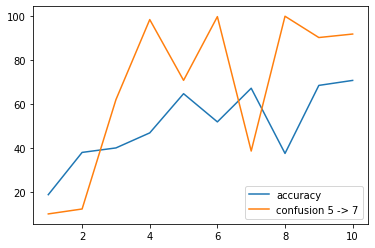

In [21]:
server, clients, test_accuracies, confusion_values = await federated_training(server_agg = 'mean', malicious_clients = {2})

Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 5.685672998428345
Client 9 finished training 5.418525218963623
Client 0 finished training 11.381448984146118
Client 1 finished training 22.638378858566284
Client 4 finished training 22.364241123199463
Client 8 finished training 22.044600009918213
Client 5 finished training 25.84960675239563
Client 6 finished training 27.593891143798828
Client 7 finished training 28.377241134643555
Client 3 finished training 31.407679080963135
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 15 %
Top 3 tensor([[9, 5, 2]]) tensor([[0.1058, 0.1052, 0.1029]], grad_fn=<TopkBackward>)
Client 0 starting training


<ipython-input-9-707262d2d600>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(trainset[special_sample][0].reshape(1, -1, 28, 28)))


Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 starting training
Client 5 starting training
Client 6 starting training
Client 7 starting training
Client 8 starting training
Client 9 starting training
Client 2 finished training 6.583028078079224
Client 9 finished training 7.308596849441528
Client 0 finished training 15.228419065475464
Client 1 finished training 30.616881847381592
Client 4 finished training 30.117207765579224
Client 8 finished training 29.511791944503784
Client 5 finished training 34.54967904090881
Client 6 finished training 36.561843156814575
Client 7 finished training 37.46102476119995
Client 3 finished training 41.2139310836792
Aggregation <All keys matched successfully>
Accuracy of the network on the 1000 test images: 39 %
Top 3 tensor([[7, 9, 5]]) tensor([[0.1109, 0.1108, 0.1048]], grad_fn=<TopkBackward>)
Client 0 starting training
Client 1 starting training
Client 2 starting training
Client 3 starting training
Client 4 sta

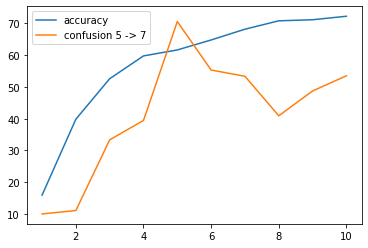

In [22]:
server, clients, test_accuracies, confusion_values = await federated_training(server_agg = 'median', malicious_clients = {2})

----

The interesting part here is, one of the clients is malicious (`is_evil=True`).

1. Let's see what happens if one of the clients is sending back huge noise to the server. Notice the changes.
2. What can the server do to survive to this attack? It can take the median of values. Replace $AGG$ with $median$ in the `Server` class and notice the changes.
3. Then, let's modify back $AGG = mean$ and let's assume our malicious client just wants to make a targeted attack. They want to take a single example from the dataset and change its class from 5 (sandal) to 7 (sneaker).

N. B. - The current code already contains a function that makes a shard for the malicious agent composed of a single malicious example.

How can the malicious client ensure that its update is propagated back to the server? Change the code and notice the changes.

4. Let's modify again $AGG = median$. Does the attack still work? Why? (This part is not graded, but give your thoughts.)

        The attack don't work since the number of 'evil' clients is much less than the total number of clients.

5. What can we do to make a stealth (more discreet) attacker? Again discuss briefly, in this doc, this part is not graded.
        
        A way to make the targeted attack work can be to train the model firstly with the benign dataset and then after trying the so obtained model with the malicious dataset. This ensures that the global shape of the modified `statedict` is similar the one of the other clients.

Please ensure that all of your code is runnable; what we are the most interested in, is the targeted attack.

In [ ]:
%%time
# Accuracy of server and clients
for model in [server.net] + [client.net for client in clients]:
    test(model, clients[2].special_sample, testloader)

In [ ]:
# For debug purposes, you can show the histogram of the weights of the benign clients compared the malicious one.
for i, model in enumerate([clients[2], server] + clients[:2][::-1]):
    plt.hist(next(model.net.parameters()).reshape(-1).data.numpy(), label=i, bins=50)
plt.legend()
plt.xlim(-0.5, 0.5)

In [ ]:
# Accuracy per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = server.net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (trainset.classes[i], 100 * class_correct[i] / class_total[i]))